In [1]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
import torch

import nltk
from nltk import word_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt

import os
os.chdir("..") # go to the root dir

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pwd

/notebooks/Text_De-toxification


In [3]:
df = pd.read_csv('data/raw/filtered_paranmt.tsv', sep='\t', index_col=0)

In [4]:
df

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
...,...,...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


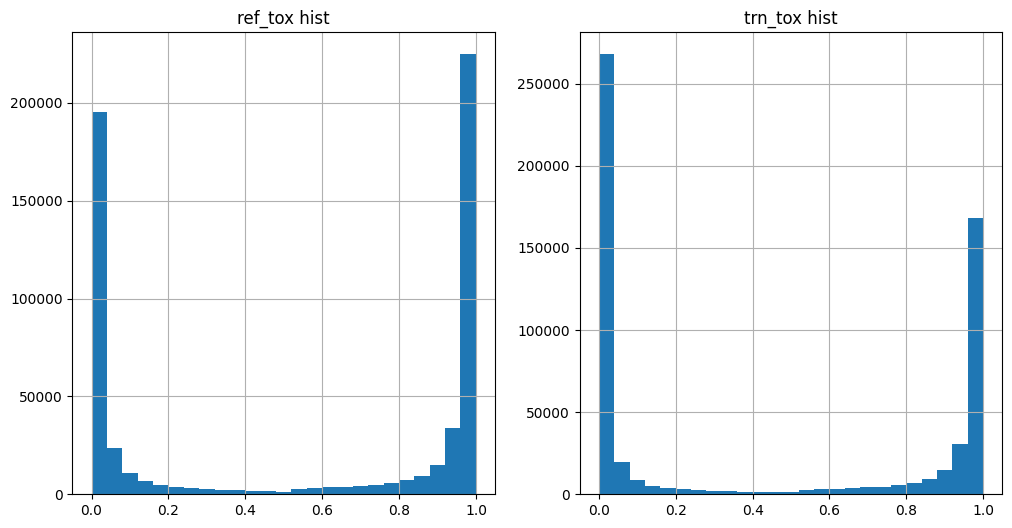

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['ref_tox'].hist(bins=25)
plt.title('ref_tox hist')

plt.subplot(1, 2, 2)
df['trn_tox'].hist(bins=25)
plt.title('trn_tox hist')

plt.show()

In [6]:
mask = df['ref_tox'] > df['trn_tox']
df['toxic_sent'] = df['reference'].where(mask, df['translation'])
df['neutral_sent'] = df['reference'].where(~mask, df['translation'])
df['toxic_val'] = df['ref_tox'].where(mask, df['trn_tox'])
df['neutral_val'] = df['ref_tox'].where(~mask, df['trn_tox'])
df = df.drop(['reference', 'translation', 'ref_tox', 'trn_tox'], axis=1)

In [7]:
df

,similarity,lenght_diff,toxic_sent,neutral_sent,toxic_val,neutral_val
0,0.785171,0.010309,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.981983,0.014195
1,0.749687,0.071429,you're becoming disgusting.,Now you're getting nasty.,0.999039,0.065473
2,0.919051,0.268293,"well, we can spare your life.","Well, we could spare your life, for one.",0.985068,0.213313
3,0.664333,0.309524,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.994215,0.053362
4,0.726639,0.181818,I have orders to kill her.,I've got orders to put her down.,0.999348,0.009402
...,...,...,...,...,...,...
577772,0.870322,0.030769,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.949143,0.000121
577773,0.722897,0.058824,It'il suck the life out of you!,you'd be sucked out of your life!,0.996124,0.215794
577774,0.617511,0.212121,"I can't fuckin' take that, bruv.",I really can't take this.,0.984538,0.000049
577775,0.679613,0.358209,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.991945,0.000124


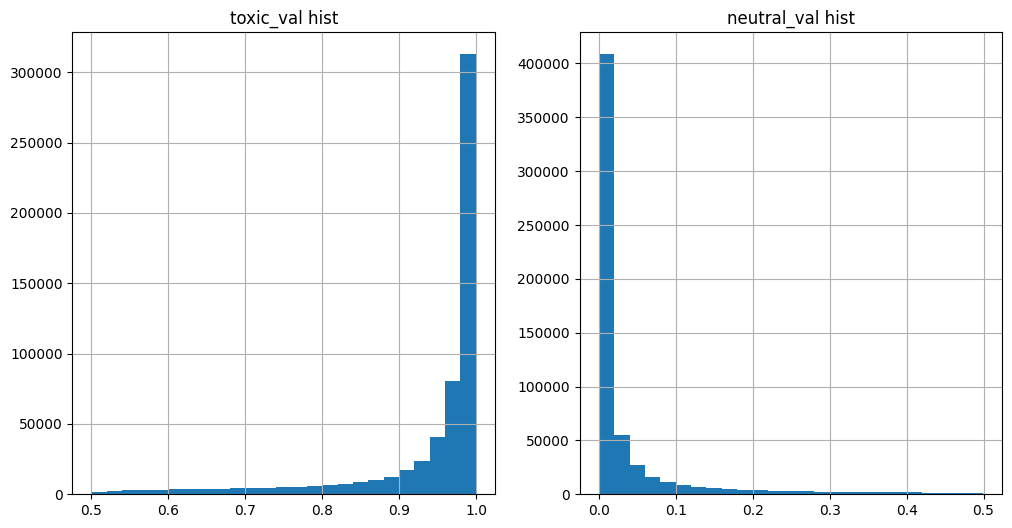

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['toxic_val'].hist(bins=25)
plt.title('toxic_val hist')

plt.subplot(1, 2, 2)
df['neutral_val'].hist(bins=25)
plt.title('neutral_val hist')

plt.show()

<Axes: >

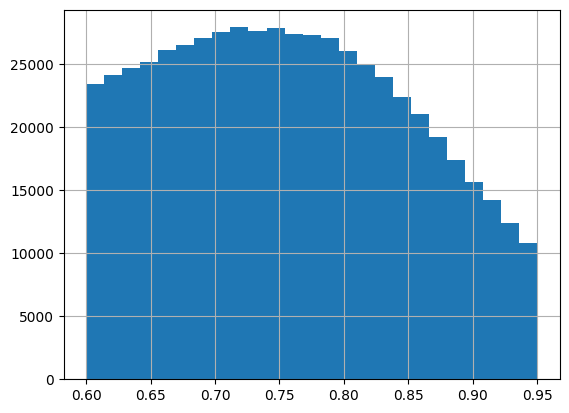

In [9]:
df['similarity'].hist(bins=25)

# Text Preprocessing Steps

In [10]:
from torchtext.vocab import build_vocab_from_iterator

# to see how many unique value do we have
# in this preprocessing steps we try to minimize the size of vocab
def build_vocab(df, min_freq=1, tokenize=True):
    def yield_tokens(df):
        for i in df.index:
            toxic_sent = df['toxic_sent'][i]
            if tokenize:
                toxic_sent = word_tokenize(toxic_sent)
            yield toxic_sent
            
            neutral_sent = df['neutral_sent'][i]
            if tokenize:
                neutral_sent = word_tokenize(neutral_sent)
            yield neutral_sent

    vocab = build_vocab_from_iterator(
        yield_tokens(df),
        min_freq=min_freq,
    )
    
    return vocab

In [11]:
print("size of vocab before text preprocessing:", len(build_vocab(df)))

size of vocab before text preprocessing: 150786


## Step 1: Lower the Text

In [12]:
def lower_text(text: str) -> str:
    return text.lower()

df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(lower_text)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(lower_text)

In [13]:
vocab = build_vocab(df)
print("size of vocab after text lowering:", len(vocab))

size of vocab after text lowering: 127757


## Step 2: Convert Contractions to normal form

examples:
- aren’t = are not
- can’t = cannot
- couldn’t = could not

We will be using contractions library

In [14]:
import contractions

df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(contractions.fix)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(contractions.fix)

In [15]:
vocab = build_vocab(df)
print("size of vocab after converting contractions:", len(vocab))

size of vocab after converting contractions: 127619


## Step 3: Word Tokenization

In [16]:
df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(word_tokenize)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(word_tokenize)

In [17]:
df

,similarity,lenght_diff,toxic_sent,neutral_sent,toxic_val,neutral_val
0,0.785171,0.010309,"[if, alkar, floods, her, with, her, mental, wa...","[if, alkar, is, flooding, her, with, psychic, ...",0.981983,0.014195
1,0.749687,0.071429,"[you, are, becoming, disgusting, .]","[now, you, are, getting, nasty, .]",0.999039,0.065473
2,0.919051,0.268293,"[well, ,, we, can, spare, your, life, .]","[well, ,, we, could, spare, your, life, ,, for...",0.985068,0.213313
3,0.664333,0.309524,"[monkey, ,, you, have, to, wake, up, .]","[ah, !, monkey, ,, you, have, got, to, snap, o...",0.994215,0.053362
4,0.726639,0.181818,"[i, have, orders, to, kill, her, .]","[i, have, got, orders, to, put, her, down, .]",0.999348,0.009402
...,...,...,...,...,...,...
577772,0.870322,0.030769,"[you, did, not, know, that, estelle, stole, yo...","[you, did, not, know, that, estelle, had, stol...",0.949143,0.000121
577773,0.722897,0.058824,"[it'il, suck, the, life, out, of, you, !]","[you, would, be, sucked, out, of, your, life, !]",0.996124,0.215794
577774,0.617511,0.212121,"[i, can, not, fuckin, ', take, that, ,, bruv, .]","[i, really, can, not, take, this, .]",0.984538,0.000049
577775,0.679613,0.358209,"[they, called, me, a, fucking, hero, ., the, t...","[they, said, i, was, a, hero, ,, but, i, did, ...",0.991945,0.000124


## Step 4: Correct Spelling

We will be using pyspellchecker library

In [18]:
from spellchecker import SpellChecker
import regex

spell = SpellChecker(distance=1)

all_words = vocab.get_itos()
misspelled_words = list(spell.unknown(all_words))
print(misspelled_words[:10])

['turncoats', 'cortean', 'highspeed', 'áres', 'rhéso', 'havemy', 'eye-socket', 'mikaela', 'triple-toothed', 'carlozenges']


In [19]:
def correct_word(word, unk=None):
    if unk is None:
        unk = word
    corrected = spell.correction(word)
    return unk if corrected is None else corrected

def correct_spellings(text: list[str]) -> list[str]:
    corrected_text = []
    misspelled_words = spell.unknown(text)
    for word in text:
        if word in misspelled_words:
            corrected_text.extend([correct_word(x) for x in regex.findall('[a-zA-Z0-9_]+', word)])
        else:
            corrected_text.append(word)
    return corrected_text

df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(correct_spellings)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(correct_spellings)

In [20]:
vocab = build_vocab(df, tokenize=False)
print("size of vocab after correcting spelling:", len(vocab))

size of vocab after correcting spelling: 79595


## Let's see what we have in the dataset

In [21]:
df

,similarity,lenght_diff,toxic_sent,neutral_sent,toxic_val,neutral_val
0,0.785171,0.010309,"[if, altar, floods, her, with, her, mental, wa...","[if, altar, is, flooding, her, with, psychic, ...",0.981983,0.014195
1,0.749687,0.071429,"[you, are, becoming, disgusting, .]","[now, you, are, getting, nasty, .]",0.999039,0.065473
2,0.919051,0.268293,"[well, ,, we, can, spare, your, life, .]","[well, ,, we, could, spare, your, life, ,, for...",0.985068,0.213313
3,0.664333,0.309524,"[monkey, ,, you, have, to, wake, up, .]","[ah, !, monkey, ,, you, have, got, to, snap, o...",0.994215,0.053362
4,0.726639,0.181818,"[i, have, orders, to, kill, her, .]","[i, have, got, orders, to, put, her, down, .]",0.999348,0.009402
...,...,...,...,...,...,...
577772,0.870322,0.030769,"[you, did, not, know, that, estelle, stole, yo...","[you, did, not, know, that, estelle, had, stol...",0.949143,0.000121
577773,0.722897,0.058824,"[it'il, suck, the, life, out, of, you, !]","[you, would, be, sucked, out, of, your, life, !]",0.996124,0.215794
577774,0.617511,0.212121,"[i, can, not, fuckin, ', take, that, ,, bruv, .]","[i, really, can, not, take, this, .]",0.984538,0.000049
577775,0.679613,0.358209,"[they, called, me, a, fucking, hero, ., the, t...","[they, said, i, was, a, hero, ,, but, i, did, ...",0.991945,0.000124


In [29]:
print(vocab.get_itos()[-100:])

['zehava', 'zeichen', 'zeitz', 'zekic', 'zekich', 'zekintha', 'zekinthu', 'zelana', 'zelenooy', 'zemarino', 'zemomuan', 'zensunnis', 'zeppelins', 'zequiel', 'zerbiba', 'zerdeppert', 'zerlina', 'zerlindo', 'zernopod', 'zeroing', 'zeroists', 'zerophiliac', 'zetko', 'zey', 'zezim', 'zheeerlika', 'zhenzoned', 'zhkopf', 'zhuangji', 'zhugea', 'ziaorou', 'ziegfeld', 'ziegfield', 'ziggurat', 'zigzag', 'zigzaggy', 'zikkurat', 'zimabu', 'zimbabwean', 'zimni', 'zimoval', 'zimovale', 'zings', 'zinnias', 'zipless', 'zippered', 'zipperwas', 'zippety', 'zippy', 'zips', 'zirconium', 'zirgou', 'zirre', 'zirry', 'zither', 'ziyoo', 'zkhundyface', 'zkurvenej', 'zkurvysyn', 'zlobenians', 'zloty', 'zmrdoxicht', 'znichhonix', 'znivim', 'zoids', 'zoloft', 'zolturi', 'zom', 'zombeaver', 'zombieee', 'zombiefied', 'zombiepoison', 'zombyish', 'zoology', 'zooms', 'zoroffs', 'zorov', 'zoxi', 'zpracov', 'zprasilwit', 'zprznitel', 'zrrp', 'zsasz', 'zsasze', 'ztroscotancova', 'zuazo', 'zubaore', 'zufe', 'zuje', 'zukey

## Step 5: Remove constractions that appeard after spell correcting

In [23]:
import contractions

def convert_contractions(text: list[str]) -> list[str]:
    return [contractions.fix(word) for word in text]

df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(convert_contractions)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(convert_contractions)

In [24]:
vocab = build_vocab(df, tokenize=False)
print("size of vocab after converting contractions 2:", len(vocab))

size of vocab after converting contractions 2: 79586


# Save the DataFrame

In [31]:
def list_to_str(text: list[str]) -> str:
    return " ".join(text)

df.loc[:, 'toxic_sent'] = df['toxic_sent'].apply(list_to_str)
df.loc[:, 'neutral_sent'] = df['neutral_sent'].apply(list_to_str)

In [32]:
df

,similarity,lenght_diff,toxic_sent,neutral_sent,toxic_val,neutral_val
0,0.785171,0.010309,"if altar floods her with her mental waste , it...","if altar is flooding her with psychic waste , ...",0.981983,0.014195
1,0.749687,0.071429,you are becoming disgusting .,now you are getting nasty .,0.999039,0.065473
2,0.919051,0.268293,"well , we can spare your life .","well , we could spare your life , for one .",0.985068,0.213313
3,0.664333,0.309524,"monkey , you have to wake up .","ah ! monkey , you have got to snap out of it .",0.994215,0.053362
4,0.726639,0.181818,i have orders to kill her .,i have got orders to put her down .,0.999348,0.009402
...,...,...,...,...,...,...
577772,0.870322,0.030769,you did not know that estelle stole your fish ...,you did not know that estelle had stolen some ...,0.949143,0.000121
577773,0.722897,0.058824,it'il suck the life out of you !,you would be sucked out of your life !,0.996124,0.215794
577774,0.617511,0.212121,"i can not fuckin ' take that , bruv .",i really can not take this .,0.984538,0.000049
577775,0.679613,0.358209,they called me a fucking hero . the truth is i...,"they said i was a hero , but i did not care .",0.991945,0.000124


In [33]:
# save the preprocessed df
df.to_csv('data/interim/preprocessed_paranmt3.tsv', sep='\t')

# All Preprocessing Steps in one function

You can use this function from `src/data/preprocessing.py`

In [34]:
import contractions
from spellchecker import SpellChecker
import regex

spell = SpellChecker(distance=1)

def correct_word(word, unk=None):
    if unk is None:
        unk = word
    corrected = spell.correction(word)
    return unk if corrected is None else corrected

def correct_spellings(text: list[str]) -> list[str]:
    corrected_text = []
    misspelled_words = spell.unknown(text)
    for word in text:
        if word in misspelled_words:
            corrected_text.extend([correct_word(x) for x in regex.findall('[a-zA-Z0-9_]+', word)])
        else:
            corrected_text.append(word)
    return corrected_text

def convert_contractions(text: list[str]) -> list[str]:
    return [contractions.fix(word) for word in text]

def preprocess_text(text: str) -> list[str]:
    # Step 1: lower the text
    text = text.lower()
    
    # Step 2: Convert Contractions to normal form
    text = contractions.fix(text)
    
    # Step 3: Word Tokenization
    text = word_tokenize(text)
    
    # Step 4: Correct Spelling
    text = correct_spellings(text)
    
    # Step 5: Remove constractions that appeard after spell correcting
    text = convert_contractions(text)
    
    return text